# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [20]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W-1
Gradient check passed!
Checking gradient for B-1
Gradient check passed!
Checking gradient for W-2
Gradient check passed!
Checking gradient for B-2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [24]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W-1
Gradient check passed!
Checking gradient for B-1
Gradient check passed!
Checking gradient for W-2
Gradient check passed!
Checking gradient for B-2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [25]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [26]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.301968, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301948, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302453, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303271, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302676, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302960, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303598, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302360, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302433, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302893, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302130, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302422, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302821, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.303380, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302890, Train acc

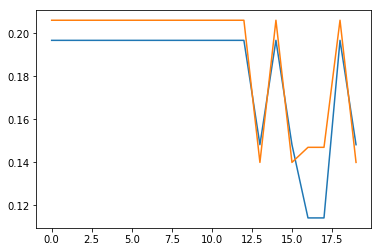

In [30]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [32]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.299105, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278326, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275751, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275156, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274574, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273708, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272808, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272191, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271801, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271684, Train accuracy: 0.196667, val accuracy: 0.206000


# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [34]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.327683, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308996, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302489, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297326, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293216, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289931, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287290, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285163, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283444, Train accuracy: 0.196667, val accuracy: 0.206000


# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [35]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335450, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.320691, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.309209, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.300474, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.289562, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.277618, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.269571, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.243243, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.206660, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.141708, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.071649, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.007283, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.982125, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.966656, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.872954, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.861067, Train acc

Loss: 1.272624, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.272314, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.275690, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.265574, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.269452, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.297819, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.271918, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.258956, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.252123, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.273934, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.279182, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.260598, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.255954, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.257909, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.266019, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.250099, Train acc

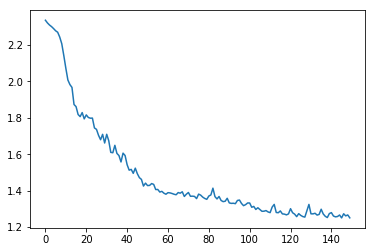

In [36]:
plt.plot(loss_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [ ]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less
def keywithmaxval(d):
    '''     
    a) create a list of the dict's keys and values; 
    b) return the key with the max value
    '''
    v = list(d.values())
    k = list(d.keys())
    return k[v.index(max(v))]

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
l_r_to_accuracy = {}

for l in learning_rates:
    for r in reg_strengths:

        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = r)
        dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
        # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
        trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=l, learning_rate_decay=0.97, num_epochs=20, batch_size=5)

        loss_history, train_history, val_history = trainer.fit()
        l_r_to_accuracy[str(l) + ', ' + str(r)] = np.average(train_history)

key_of_best = keywithmaxval(l_r_to_accuracy)
print(keywithmaxval(l_r_to_accuracy), ' accuracy is ', (l_r_to_accuracy[key_of_best]))

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [40]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

best_classifier = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 110, reg = 1e-6)
dataset = Dataset(train_X, train_y, val_X, val_y)
best_trainer = Trainer(best_classifier, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.97, num_epochs=50, batch_size=64)
loss_history, train_history, val_history = best_trainer.fit()

best_val_accuracy = np.average(val_history)


# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.155419, Train accuracy: 0.323556, val accuracy: 0.327000
Loss: 1.686660, Train accuracy: 0.525444, val accuracy: 0.515000
Loss: 1.577587, Train accuracy: 0.583333, val accuracy: 0.563000
Loss: 1.262616, Train accuracy: 0.654333, val accuracy: 0.623000
Loss: 1.156276, Train accuracy: 0.654889, val accuracy: 0.634000
Loss: 1.108657, Train accuracy: 0.675000, val accuracy: 0.631000
Loss: 1.012785, Train accuracy: 0.708333, val accuracy: 0.646000
Loss: 0.932605, Train accuracy: 0.732444, val accuracy: 0.673000
Loss: 0.874449, Train accuracy: 0.746556, val accuracy: 0.664000
Loss: 0.858742, Train accuracy: 0.722444, val accuracy: 0.680000
Loss: 0.804776, Train accuracy: 0.798333, val accuracy: 0.705000
Loss: 0.748913, Train accuracy: 0.777556, val accuracy: 0.705000
Loss: 0.703203, Train accuracy: 0.814000, val accuracy: 0.720000
Loss: 0.652840, Train accuracy: 0.781333, val accuracy: 0.693000
Loss: 0.638339, Train accuracy: 0.838444, val accuracy: 0.722000
Loss: 0.547799, Train acc

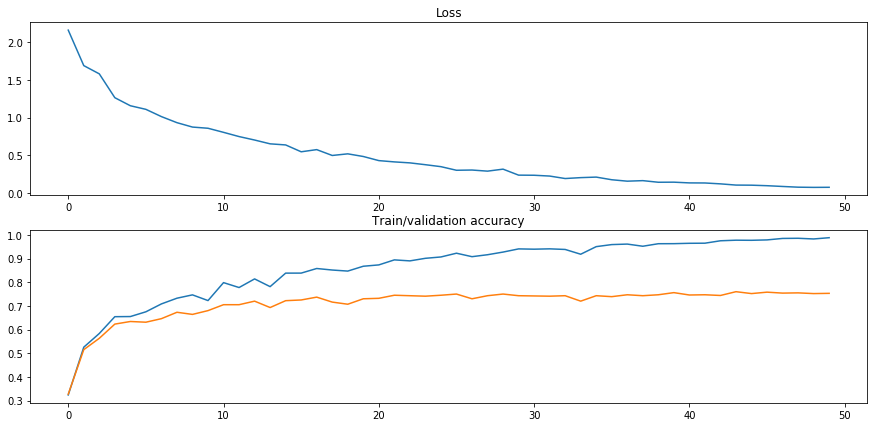

In [41]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [42]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.739000
